## Load the Dataset
MNIST is a dataset of 70,000 handwritten images. Keras provides a function to directly download the data.
<br>The dataset is then split into 60K training images and 10K test images.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #load and split data 

## Normalize the images
The input are 28 pixels by 28 pixels images. They are represented in grayscale, which means each pixel is a single number between 0 and 255. 0 is a black pixel and 255 is a white pixel.
<br>Before training, it is a good practice to normalize the data. In our case the min-max scaler is used to get values between 0 and 1.

In [49]:
# Convert datasets to float
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# Normalize the pixel data
x_train /= 255.0
x_test  /= 255.0

## Construct the NN model

Our NN will have the following structure
1. **AveragePooling:** This layer turns a 28x28 image to 14x14. It takes the input image and transforms each 4x4 sub-matrix by replacing it with its average value.
2. **Flatten:** This layer converts a 14x14 matrix to a 196x1 1D vector. This conversion is needed for the next layers.
3. **Dense layer 1:** In a dense layer (also known as a fully connected layer), the output of each neuron is calculated by a weighted sum of the inputs from all neurons in the preceding layer. This sum is passed through an activation function before being propagated to the next layer.
4. **Dense layer 2:** The output layer has 10 neurons: one for each of the possible digit. The neuron with the largest value corresponds to the recognized digit.

In [50]:
# Importing Keras model and layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, AveragePooling2D

# Construct the NN by stacking all required layers
model_s_nn = Sequential() # Sequential: the layers will be connected to one another
model_s_nn.add(AveragePooling2D(pool_size=(2, 2), input_shape=(28, 28, 1)))
model_s_nn.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model_s_nn.add(Dense(32, activation=tf.nn.relu))
model_s_nn.add(Dense(10,activation=tf.nn.softmax))
model_s_nn.summary() # Print NN summary

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_15 (Avera  (None, 14, 14, 1)        0         
 gePooling2D)                                                    
                                                                 
 flatten_15 (Flatten)        (None, 196)               0         
                                                                 
 dense_30 (Dense)            (None, 32)                6304      
                                                                 
 dense_31 (Dense)            (None, 10)                330       
                                                                 
Total params: 6,634
Trainable params: 6,634
Non-trainable params: 0
_________________________________________________________________


## Train the Model

The model can now be trained using the training dataset. For each image x_train(i), the model will try to find the associated digit y_train(i). It will gradually adjust the values for the different weights and biases of the dense layers.

In [51]:
# Train the model
model_s_nn.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) # Train on accuracy
model_s_nn.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5000 - accuracy: 0.8675
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2609 - accuracy: 0.9257
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2184 - accuracy: 0.9379
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1887 - accuracy: 0.9460
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1668 - accuracy: 0.9516
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1502 - accuracy: 0.9560
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1374 - accuracy: 0.9595
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1270 - accuracy: 0.9622
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1188 - accuracy: 0.9648
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.112

## Test the model
The accuracy of the model on the training set is approx 97%, which is pretty good. 
<br>To ensure that the model will actually perform well on new data and has not just 'learned' the training set, we need to test it on new data.
Note that 'learning' the dataset is known as overfitting.

In [52]:
# Test the trained model
model_s_nn.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 0.9621


[0.12868091464042664, 0.9621000289916992]

As we can see, our model performs well on unseen data. We will now turn the biases and weights to Verilog vectors.

## Explore the weights used by the model and Quantize
The trained model has a set of weights and biases for each neuron. The output of a neuron is being calculated as: out(n)=Sum(wn(k)*in(k))+b(n).
<br>A 5 neurons layer which takes into input a vector of 20 elements has:
* 5 biases, one per neuron
* 20*5 weights, 20 per neuron
<br><br>
Those biases and neurons are coded as floats, which would take too much space. We will reduce these to 8 bits so that it can be stored into our board.
<br> The verilog arrays generated are indexed as follows:  array_layer[neuron_num][weight_num]


In [4]:
# Define some helper functions that will quantize an array to N bits / print the result

# Returns a quantized array
# Arguments:     
# use_scale       If non-zero it will use this instead of auto-computing the scaling factor.
# Returns:
# out             The quantized data
# out_int         The quantized data, but scaled to an int value in the range +/- (2**n_bit-1)-1
# scale           The scaling factor used between out and out_int

def quantize_nbit(data, n_bit, use_scale=0, verbose=0):
    max_bit_val = (2**(n_bit-1))-1
    max_val     = np.max(np.abs(data))
    if use_scale > 0:
        scale = use_scale
    else :
        scale   = max_bit_val / max_val 
    if verbose:
        print('Quantizing to +/- {}, scaling by {}'.format(max_bit_val, scale))
        
    out_int = np.around(data * scale)
    out = out_int /  scale
    
    return out, out_int, scale

import IPython.display as dp
def print_nowrap(s):
    display(dp.HTML("<style>.nowrap{white-space:nowrap;}</style><span class='nowrap'>" +s+ "</span>"))

In [54]:
# Quantize and Export the weights
n_bit               = 8            # Number of bits to quantize to
quantized_wb        = [0,0,0,0]
quantized_wb_scale  = [0,0,0,0]

print(model_s_nn.layers)

for l,layer in enumerate(model_s_nn.layers):
    if len(layer.weights)>0:
        w,b = layer.weights
        w,b = w.numpy(), b.numpy()
        print('Layer {} - Array Shape/Range: Weights = {}, Biases = {}'.format(l, w.shape, b.shape))
        w_q, w_qi, scale = quantize_nbit(w, n_bit, verbose=1)
        b_q, b_qi, _     = quantize_nbit(b, n_bit, use_scale=scale)
        
        # Print the scaled values
        num_w, num_neuron = w.shape
        
        # Print the Biases as an SV parameter array
        s = "localparam signed [{}:0] B_ARRAY_L{} [0:{}] = '{{ {} }};".format(n_bit-1, l, num_neuron-1, ', '.join(str(int(e)) for e in b_qi))
        print_nowrap(s)
        
        # Print Weights as an SV parameter array
        s = "localparam signed [{}:0] W_ARRAY_L{} [0:{}] [0:{}] = '{{<br>".format(n_bit-1, l, num_neuron-1, len(w_qi[:,0])-1)
        for n in range(num_neuron) :
            # Note: you can change
            #s += "Layer {}, Neuron {}, Bias = {}, Weights = {}<br>".format(l, n, int(b_qi[n]), ', '.join(str(int(e)) for e in w_qi[:,n]))
            #s += "bias_l{}[{}] = {}; weight_l{}[{}] = {{ {} }}<br>".format(l, n, int(b_qi[n]), l, n, ', '.join(str(int(e)) for e in w_qi[:,n]))
            s += "{{ {} }},<br>".format(', '.join(str(int(e)) for e in w_qi[:,n]))
        s = s[0:-5] # remove last comma
        s += "<br>};<br>"
        print_nowrap(s)
        
            
        # Save the quantized weights/bias for use later
        quantized_wb[l]       = (w_qi, b_qi)
        quantized_wb_scale[l] = (w_q,  b_q)
        

[<keras.layers.pooling.average_pooling2d.AveragePooling2D object at 0x0000025542BD3250>, <keras.layers.reshaping.flatten.Flatten object at 0x00000255737FE500>, <keras.layers.core.dense.Dense object at 0x0000025542B8BDC0>, <keras.layers.core.dense.Dense object at 0x0000025542B8B9D0>]
Layer 2 - Array Shape/Range: Weights = (196, 32), Biases = (32,)
Quantizing to +/- 127, scaling by 55.62836738975581


Layer 3 - Array Shape/Range: Weights = (32, 10), Biases = (10,)
Quantizing to +/- 127, scaling by 45.52645992341783


The weights and biases are available above and can be added to the Verilog code. 

## Creation of test vectors

This function transform images in test vectors to be used in the Verilog code.

In [2]:
# Write data out in the form
# logic signed [7:0] data [0:N-1] = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 4, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 0, 82, 9, 0, 0, 0, 0, 95, 0, 0, 0, 0, 0, 0, 26, 98, 0, 0, 0, 0, 20, 102, 0, 0, 0, 0, 0, 0, 56, 73, 0, 0, 0, 0, 39, 86, 0, 0, 0, 0, 1, 32, 114, 40, 0, 0, 0, 0, 38, 103, 51, 63, 83, 91, 89, 55, 121, 4, 0, 0, 0, 0, 0, 36, 44, 44, 19, 0, 0, 33, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0};
def test_data_to_verilog(n_bit, data, show_img=0, suffix=''):

    # Input data - Flatten into 1-d vector
    m_output = data.reshape(1, np.prod(data.shape)) 
    m_output = m_output[0]

    # check the output shape is 1D
    if m_output.shape[0] != m_output.size:
        print('Error: Model output is not 1D. Check the model and layer requested')
    
    # Show the image if requested
    if show_img:
        plt.subplot(111)
        dim=int(np.sqrt(m_output.size))
        plt.imshow(m_output.reshape(dim,dim), cmap='Greys')
        plt.show()
    
    # Quantize
    data_q, data_qi, scale = quantize_nbit(m_output, n_bit)
    
    # Print this arry to verilog
    s = "logic signed [{}:0] test_data{} [0:{}] = '{{ {} }};".format(n_bit-1, suffix, data_qi.size-1, ', '.join(str(int(e)) for e in data_qi))
    print_nowrap(s)
    
    return data_q, data_qi

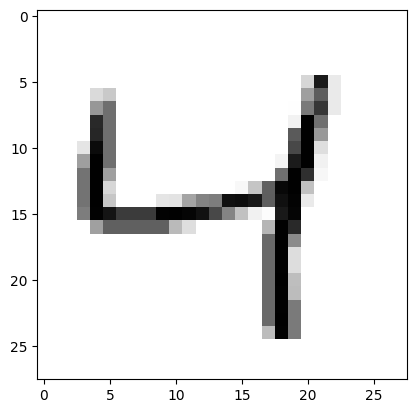

In [5]:
test_data, test_data_int = test_data_to_verilog(8,x_train[2],show_img=1)